In [ ]:
import pickle
import random
import tarfile
import numpy as np
import matplotlib.pyplot as plt
import os
import matplotlib.image as img
import cv2
import time
from tqdm import tqdm
import sys
import pyprind
import pandas as pd

from PIL import Image

In [ ]:

def get_all_jpeg_files_paths(path):
    returnedFiles = []
    print(os.walk(path))
    for  r,d, files in os.walk(path):
        for file in files:
            if '.jpeg' in file:
                returnedFiles.append(os.path.join(r,file))
    return returnedFiles

In [ ]:
train_normal_data_dir = r"d:\machineLearning-dataScience\chest-xray-pneumonia\chest_xray\chest_xray\train\NORMAL"
train_normal_data_files = get_all_jpeg_files_paths(train_normal_data_dir) 


In [ ]:
train_pneumonia_data_dir=r"d:\machineLearning-dataScience\chest-xray-pneumonia\chest_xray\chest_xray\train\PNEUMONIA"
train_pneumonia_data_files = get_all_jpeg_files_paths(train_pneumonia_data_dir)
test_normal_data_dir = r"d:\machineLearning-dataScience\chest-xray-pneumonia\chest_xray\chest_xray\test\NORMAL"
test_normal_data_files = get_all_jpeg_files_paths(test_normal_data_dir)
test_pneumonia_data_dir = r"d:\machineLearning-dataScience\chest-xray-pneumonia\chest_xray\chest_xray\test\PNEUMONIA"
test_pneumonia_data_files = get_all_jpeg_files_paths(test_pneumonia_data_dir)
valid_normal_data_dir = r"d:\machineLearning-dataScience\chest-xray-pneumonia\chest_xray\val\NORMAL"
valid_normal_data_files = get_all_jpeg_files_paths(valid_normal_data_dir)
valid_pneumonia_data_dir = r"d:\machineLearning-dataScience\chest-xray-pneumonia\chest_xray\val\PNEUMONIA"
valid_pneumonia_data_files = get_all_jpeg_files_paths(valid_pneumonia_data_dir)

In [ ]:
print(len(train_normal_data_files))
print(len(train_pneumonia_data_files))
image = img.imread(train_normal_data_files[1])
pneumonia_image = img.imread(train_pneumonia_data_files[0])
print(image.shape)
print(image.shape)

plt.imshow(image, cmap="binary")

In [ ]:
def find_median_dimensions_from_files(paths_array):
    xAxis = []
    yAxis = []

    for path in pyprind.prog_percent(paths_array):
        image = img.imread(path)
        xAxis.append(image.shape[0])
        yAxis.append(image.shape[1])
    
    return np.median(xAxis), np.median(yAxis)

xAxisMedian, yAxisMedian = find_median_dimensions_from_files(train_normal_data_files)
print(xAxisMedian, yAxisMedian)


In [ ]:
SIZE = (int(xAxisMedian), int(yAxisMedian))
imageResized = cv2.resize(image, (int(yAxisMedian), int(xAxisMedian)))
print(imageResized.shape)
print(SIZE[0]/SIZE[1])

In [ ]:
def pooling(matrix, strides, method = 'max'): 
    m, n = matrix.shape[:2]
    strideY, strideX = strides
    mY=m//strideY
    nX=n//strideX
    matrix_pad = matrix[:mY*strideY, :nX*strideX, ...]
    print(matrix.shape[2:])
    
    new_shape=(mY,strideY,nX,strideX)+matrix_pad.shape[2:]
    print(n)
    if method == 'mean':
        result = np.nanmean(matrix_pad.reshape(new_shape),axis=(1,3))
    elif method=='max':
        result = np.nanmax(matrix_pad.reshape(new_shape), axis=(1,3))
    else:
        result = np.nanmin(matrix_pad.reshape(new_shape), axis=(1,3))

    return result

def flatten(matrix):
    if len(matrix.shape) == 2:
        return matrix.reshape(matrix.shape[0]*matrix.shape[1])
    else:
        return matrix.reshape(matrix.shape[0]*matrix.shape[1],matrix.shape[2])

In [ ]:
pneumonia_imageResized = cv2.resize(pneumonia_image,(SIZE[1], SIZE[0]))
SIZE = (SIZE[0]//10*2,SIZE[1]//10*2)
imageResized_2 = cv2.resize(imageResized, (SIZE[1],SIZE[0]))
imageResized_maxPooling = pooling(imageResized, (10,10))
pneumonia_image=img.imread(train_pneumonia_data_files[0])
pneumonia_imageResized_2 = cv2.resize(pneumonia_imageResized, (SIZE[1],SIZE[0]))
pneumonia_imageResized_maxPooling = pooling(pneumonia_imageResized, (10,10))
plt.matshow(imageResized, cmap="binary")
plt.matshow(imageResized_2, cmap="binary")
plt.matshow(imageResized_maxPooling, cmap="binary")
plt.matshow(pneumonia_imageResized, cmap='binary')
plt.matshow(pneumonia_imageResized_2, cmap='binary')
plt.matshow(pneumonia_imageResized_maxPooling, cmap='binary')
plt.show()


In [ ]:
def load_data_from_files(paths_array):
    data = np.array([])
#     separating in more data-sets improves speed by over 40 time because np.dstack on high numbers is very slow
    data_sets = [np.array([])]
    current_set = 0
    for path in pyprind.prog_percent(paths_array):
        currentImage = img.imread(path)
        currentImageResized = cv2.resize(currentImage, (SIZE[1],SIZE[0]))
        if len(currentImageResized.shape) == 3:
            currentImageResized = currentImageResized[:,:,0]
        if data_sets[current_set].shape[0] != currentImageResized.shape[0]:
            data_sets[current_set] = currentImageResized
            data_sets[current_set] = data_sets[current_set].reshape(data_sets[current_set].shape[0],data_sets[current_set].shape[1],1)
        else:
            data_sets[current_set] = np.dstack((data_sets[current_set],currentImageResized))
        if data_sets[current_set].shape[2]>50:
            data_sets.append(np.array([]))
            current_set=current_set+1
    
    for data_set in pyprind.prog_percent(data_sets):
        if data.shape[0] != data_set.shape[0]:
            data = data_set
        else:
            data = np.dstack((data,data_set))
    
    return data

normal_train_data = load_data_from_files(train_normal_data_files)
print(normal_train_data.shape)
print(len(train_normal_data_files))
pneumonia_train_data = load_data_from_files(train_pneumonia_data_files)
print(pneumonia_train_data.shape)
print(len(train_pneumonia_data_files))


In [ ]:

print(normal_train_data.shape)
print(pneumonia_train_data.shape)
print(SIZE)
all_train_data = np.dstack((normal_train_data,pneumonia_train_data))
print(all_train_data.shape)
# all_train_data = flatten(all_train_data)
print(all_train_data.shape)


In [ ]:
def transform_into_list_with_results(data,dataType):
    normal_data_length = None
    if dataType == 'train':
        normal_data_length = len(train_normal_data_files)
    if dataType == 'test':
        normal_data_length = len(test_normal_data_files)
    if dataType == 'valid':
        normal_data_length = len(valid_normal_data_files)
    print(normal_data_length)
    
    train_data_with_results = list() 
    for  i in pyprind.prog_percent(range(len(data[0]))): 
        if i < normal_data_length:
            train_data_with_results.append((data[:,i], 0))
        else:
            train_data_with_results.append((data[:,i], 1)) 
    return train_data_with_results
# train_data_with_results =  transform_into_list_with_results(all_train_data,'train') 


In [ ]:

# print(train_data_with_results[0][0].shape)
test_normal_data = load_data_from_files(test_normal_data_files)
test_pneumonia_data = load_data_from_files(test_pneumonia_data_files)
all_test_data = np.dstack((test_normal_data,test_pneumonia_data))
# all_test_data = flatten(all_test_data)
# test_data = transform_into_list_with_results(all_test_data,'test')  
print(all_test_data.shape)


In [ ]:
# print(len(train_data_with_results))

In [ ]:
valid_normal_data = load_data_from_files(valid_normal_data_files)
valid_pneumonia_data = load_data_from_files(valid_pneumonia_data_files)
all_valid_data = np.dstack((valid_normal_data,valid_pneumonia_data))
# all_valid_data = flatten(all_valid_data)
# validation_data = transform_into_list_with_results(all_valid_data,'valid')  
print(all_valid_data.shape)
# print(len(validation_data))

In [ ]:
from __future__ import  absolute_import, division, print_function, unicode_literals

import tensorflow as tf
from tensorflow import keras

In [ ]:
def return_labels(data,dataType):
    normal_data_length = None
    if dataType == 'train':
        normal_data_length = len(train_normal_data_files)
    if dataType == 'test':
        normal_data_length = len(test_normal_data_files)
    if dataType == 'valid':
        normal_data_length = len(valid_normal_data_files)
    print(normal_data_length)
    
    pneumonia_data_length = (data.shape[0]-normal_data_length )
    print(pneumonia_data_length)
    results = np.concatenate((np.zeros(normal_data_length),np.ones(pneumonia_data_length)),0)
    print(results.shape)
    return results

# train_labels = return_labels(all_train_data,'train')
# all_train_data = np.swapaxes(all_train_data,2,0)
print(all_train_data.shape+(1,))
# all_train_data = np.reshape(all_train_data,(all_train_data.shape+(1,)))
print(all_train_data.shape)
test_labels = return_labels(all_test_data,'test')
valid_labels = return_labels(all_valid_data,'valid')
# all_valid_data = np.swapaxes(all_valid_data,2,0)
print(all_valid_data.shape)
# all_test_data = np.swapaxes(all_test_data,2,0)
# all_test_data = np.reshape(all_test_data,(all_test_data.shape+(1,)))
print(all_test_data.shape)
normal_train_data = None 
pneumonia_train_data = None
test_normal_data = None 
test_pneumonia_data = None

In [182]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

model=Sequential([
#     keras.layers.Flatten(input_shape=SIZE),
         keras.layers.Conv2D(8, (3,1), padding='same', activation='relu', input_shape=(328,264,1)),
     keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(8,(3,1), activation='relu'),
    keras.layers.MaxPooling2D(),
    keras.layers.Conv2D(16,(3,1), activation='relu'),
    keras.layers.MaxPooling2D(),
    Dropout(0.2),
    keras.layers.Flatten(),
    keras.layers.Dense(1353, activation = 'relu'),
    keras.layers.Dense(64, activation = 'relu'),
    keras.layers.Dense(1, activation = 'sigmoid')
])





In [188]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy','Recall'])

model.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_80 (Conv2D)           (None, 328, 264, 8)       32        
_________________________________________________________________
max_pooling2d_80 (MaxPooling (None, 164, 132, 8)       0         
_________________________________________________________________
conv2d_81 (Conv2D)           (None, 162, 132, 8)       200       
_________________________________________________________________
max_pooling2d_81 (MaxPooling (None, 81, 66, 8)         0         
_________________________________________________________________
conv2d_82 (Conv2D)           (None, 79, 66, 16)        400       
_________________________________________________________________
max_pooling2d_82 (MaxPooling (None, 39, 33, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 39, 33, 16)      

In [189]:
history = model.fit(
    np.float32(all_train_data[:2700]),
    train_labels[:2700],
    steps_per_epoch=20,
    epochs=5,
    validation_data=(all_test_data,test_labels),
    shuffle = True,
#     validation_steps=10
)

Train on 2700 samples, validate on 624 samples
Epoch 1/5
2700/2700 [==============================] - 116s 43ms/sample - loss: 17.3184 - accuracy: 0.6041 - Recall: 0.6269 - val_loss: 2.6560 - val_accuracy: 0.7051 - val_Recall: 0.9795
Epoch 2/5
2700/2700 [==============================] - 107s 40ms/sample - loss: 0.6778 - accuracy: 0.8893 - Recall: 0.8675 - val_loss: 1.0848 - val_accuracy: 0.8462 - val_Recall: 0.9051
Epoch 3/5
2700/2700 [==============================] - 98s 36ms/sample - loss: 0.2925 - accuracy: 0.9393 - Recall: 0.9397 - val_loss: 1.6246 - val_accuracy: 0.7692 - val_Recall: 0.9795
Epoch 4/5
2700/2700 [==============================] - 105s 39ms/sample - loss: 0.1077 - accuracy: 0.9652 - Recall: 0.9706 - val_loss: 0.8901 - val_accuracy: 0.8285 - val_Recall: 0.9667
Epoch 5/5
2700/2700 [==============================] - 107s 40ms/sample - loss: 0.0589 - accuracy: 0.9807 - Recall: 0.9794 - val_loss: 0.9586 - val_accuracy: 0.8125 - val_Recall: 0.9769


In [226]:
model.save('firstSave.model')

INFO:tensorflow:Assets written to: firstSave.model\assets


dict_keys(['loss', 'accuracy', 'Recall', 'val_loss', 'val_accuracy', 'val_Recall'])
[0.7051282, 0.84615386, 0.7692308, 0.82852566, 0.8125]


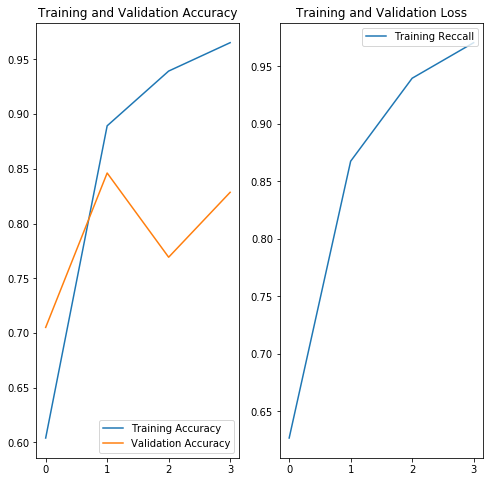

In [199]:
# model = tf.keras.models.load_model('firstSave.model')
# model.evaluate(all_valid_data)
# print(np.reshape(all_valid_data,(16,328,264)).shape)
# model.evaluate(all_test_data,test_labels)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print(history.history.keys())
print(val_acc)


Recall = history.history['Recall']
val_Recall = history.history['val_Recall']

epochs_range = range(4)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc[:4], label='Training Accuracy')
plt.plot(epochs_range, val_acc[:4], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, Recall[:4], label='Training Reccall')
# plt.plot(epochs_range, val_Recall[:4], label='Validation Recall')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
model.load('firstSave.model')